## 网站
Indeed  
Glassdoor  
Linkedin  

In [1]:
import urllib.request as urlrequest
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import string
import spacy  # please download this package first
import pandas as pd
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 

## Text Mining

In [11]:
"""
NLP all job descriptions of one keyword
Getting rid of categories of words we don't want
"""
def nlp_words(descriptions):
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(descriptions)
    tokens = []  # tokens we want
    token_drop = ['experience', 'requirements', 'new', 'ability', 'skills', 'work', 'working', 'strong', 'including', 'job',
                 'knowledge', 'industry', 'support', 'analyst', 'provide', 'responsibilities', 'qualifications', 'summary',
                 'etc', 'eg', 'plus', 'need', 'required', 'opportunities', 'create', 'related', 'employer', 'opportunity', 
                  'equal']
    dep_drop = ['pobj']
    pos_remain = ['NOUN', 'ADJ']

    for token in doc:
        if token.pos_ in pos_remain and token.dep_ not in dep_drop and not token.is_stop and str(token) not in token_drop:
            tokens.append(str(token))
    
    # finalized words we want
    wc_words = ''
    for word in descriptions.split():
        if word not in tokens:
            continue
        wc_words = wc_words + ' ' + word

    return wc_words

In [3]:
"""
Plot word counts
"""
def plot_wordcount(wc_words, select_top=15):
    """count words in job description
    """
    def word_count(str):
        counts = dict()
        words = str.split()

        for word in words:
            if word in counts:
                counts[word] += 1
            else:
                counts[word] = 1

        return counts
    
    res_count = word_count(wc_words)
    count_pd = pd.Series(res_count).sort_values(ascending=False)
    count_pd.to_csv('word_count.csv', header=True)
    count_top = count_pd[:select_top]
    print(count_top)
    plt.figure(figsize=(16,7))
    plt.bar(count_top.index, count_top.values)
    plt.show()

In [4]:
"""
Plot wordcloud
"""
def plot_wordcloud(wc_words):
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = set(STOPWORDS) , 
                    min_font_size = 10).generate(wc_words) 

    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 

## Indeed

In [14]:
"""
Main function
"""
def Indeed_Search_Keywords(keyword, search_no, count=50):  # maximum 50
    job = str.lower(keyword).replace(' ', '+')
    start_list = range(0, search_no, count)
    
    """
    get a list of urls 
    """
    url_list = []
    
    for start in start_list:  # for each page starting at link start to link (start+count)
        url_visit = 'https://www.indeed.com/jobs?q='+job+'&l=New+York,+NY&start='+str(start)+'&limit='+str(count)
#         print(url_visit)
        crawl_content = urlrequest.urlopen(url_visit).read()
        soup = BeautifulSoup(crawl_content, "html.parser")
        tbl = soup.find(id="resultsCol")
        url_begin = 'https://www.indeed.com'

        for link in tbl.find_all('a', attrs = {'class' : 'turnstileLink'}):
            url = link.attrs['href']
            if 'pagead' not in url and 'cmp' not in url:
                final_url = urljoin(url_begin, url)
                url_list.append(final_url)
#                 print(len(url_list), final_url)

    """preprocess job decription"""
    def process_string(description):
        description = str.lower(description)
        paragraph = description.split('\n')
        try:
            indices = [i for i, s in enumerate(paragraph) if 'responsibilities' in s]
            paragraph = paragraph[indices[0]:]
        except:
            pass
        paragraph = [line for line in paragraph if not any(check in line 
                                                           for check in ['qualification', '.com', '?', 'email'])]
        description = ' '.join(paragraph)
        descript = description.translate(str.maketrans('', '', string.punctuation))
        return descript

    """
    store url, job name and job description for each url into pandas dataframe
    """
    data = pd.DataFrame(columns=['url', 'job', 'job description'])
    descriptions = ''  # all job descriptions together

    for url in url_list:
        soup = BeautifulSoup(urlrequest.urlopen(url).read(), "html.parser")
        job_title = soup.title.string.split('-')[0][:-1]
        description = soup.find('div', attrs={'id': 'jobDescriptionText'}).text
        data = data.append(pd.Series([url, job_title, description], index=['url', 'job', 'job description']), 
                           ignore_index=True)
#         data.to_csv('indeed_'+keyword+'.csv')
        descriptions = descriptions + process_string(description)
    
    print('Indeed: Finished searching keyword -', keyword, '...')
    
    return descriptions

## Linkedin

In [31]:
def Linkedin_Search_Keywords(keyword, search_no):
    job = str.lower(keyword).replace(' ', '%20')
    start_list = range(0, search_no, 25)  # 25 links per page
    
    """
    get a list of urls 
    """
    url_list = []
    
    for start in start_list:  # for each page starting at link start to link (start+count)
        url_visit = 'https://www.linkedin.com/jobs/search/?geoId=105080838&keywords='+job+ \
                    '&location=New%20York%2C%20United%20States&start='+str(start)
#         print(url_visit)
        crawl_content = urlrequest.urlopen(url_visit).read()
        soup = BeautifulSoup(crawl_content, "html.parser")

        for link in soup.find_all('a', class_='result-card__full-card-link'):
            url = link.attrs['href']
            url_list.append(url)

    """preprocess job decription"""
    def process_string(descript_list):
        paragraph = [str.lower(line) for line in descript_list]
        try:
            start_indices = [i for i, s in enumerate(paragraph) if 
                             'responsibilities' or 'requirements' or 'qualifications' or 'you' or 'summary' in s]
            paragraph = paragraph[start_indices[0]:]
        except:
            pass
        try:
            end_indices = [i for i, s in enumerate(paragraph) if 
                             'location' or 'date' or 'employer' or 'offer' or 'physical' in s]
            paragraph = paragraph[:end_indices[0]]
        except:
            pass

        description = ' '.join(paragraph)
        descript = description.translate(str.maketrans('', '', string.punctuation))
        return descript

    """
    store url, job name and job description for each url into pandas dataframe
    """
    data = pd.DataFrame(columns=['url', 'job', 'company', 'job description'])
    descriptions = ''  # all job descriptions together

    for url in url_list:
        soup = BeautifulSoup(urlrequest.urlopen(url).read(), "html.parser")
        try:
            job_title = soup.find('h1', class_='topcard__title').text
            job_company = soup.find('span', class_='topcard__flavor').text
            tag_list = soup.find('div', class_='description__text description__text--rich').find_all(True, recursive=False)
        except:
            job_title = ''
            job_company = ''
            tag_list = ''
            
        descript_list = []
        for tag in tag_list:
            list = tag.find_all(True)
            descript_list.extend(list)
        descript_list = [tag.text for tag in descript_list]
        description = ' '.join(descript_list)
        
        data = data.append(pd.Series([url, job_title, job_company, description], 
                                     index=['url', 'job', 'company', 'job description']), 
                           ignore_index=True)
#         data.to_csv('linkedin_'+keyword+'.csv')
        descriptions = descriptions + process_string(descript_list)
    
    print('Linkedin: Finished searching keyword -', keyword, '...')
    
    return descriptions

## Run

In [25]:
"""Enter your Parameters
# enter your keyword as first parameter
# search_no (number of search results you want) as second parameter
"""
search_no = 100
keywords = ["Data Analytics", "Data Scientists", "Digital Marketing", "Business Analytics", 
            "Investment Banking", "Private Equity Analyst", "Quantitative Finance Analyst", "Marketing", "Public Relations"]
keyword = keywords[-3]  # can be any job string

Linkedin: Finished searching keyword - Public Relations ...
https://www.indeed.com/jobs?q=public+relations&l=New+York,+NY&start=0&limit=50
https://www.indeed.com/jobs?q=public+relations&l=New+York,+NY&start=50&limit=50
Indeed: Finished searching keyword - Public Relations ...
media             313
relations         150
press             141
public            138
communications    132
team              124
pr                109
events             97
social             90
business           77
communication      70
years              69
clients            65
relationships      65
marketing          64
dtype: int64


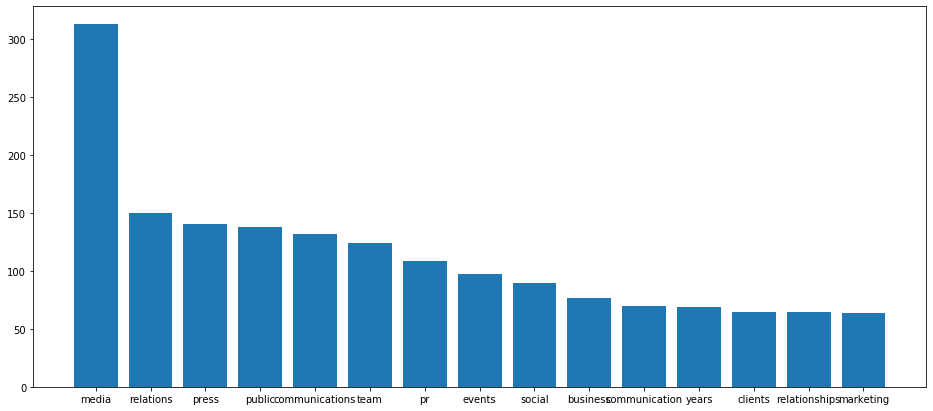

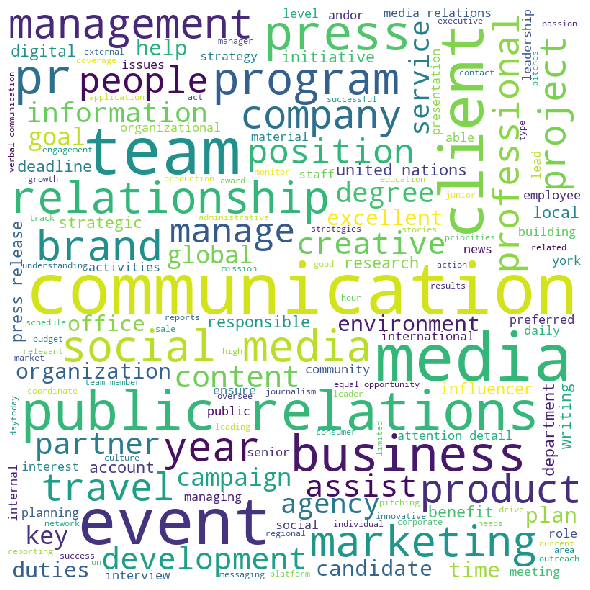

In [33]:
for keyword in keywords[-1:]:
    linkedin = Linkedin_Search_Keywords(keyword, search_no)
    indeed = Indeed_Search_Keywords(keyword, search_no)
    descriptions = linkedin + indeed

    """NLP all job descriptions of one keyword"""
    wc_words = nlp_words(descriptions)

    """Plot word counts"""
    plot_wordcount(wc_words)

    """Show wordcloud"""
    plot_wordcloud(wc_words)